# **Hospital Cost and Outcome Dashboard**
Visual Analytics and Predictive Modeling using CMS Healthcare Data

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from  sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [2]:
hrrp_data=pd.read_csv("/content/Hospital_Readmissions_Reduction_Program_Hospital.csv")

In [3]:
geninfo_data=pd.read_csv("/content/Hospital_General_Information.csv")

In [4]:
medicare_data=pd.read_csv("/content/Medicare_IP_Hospitals_by_Provider_2023.csv", encoding='latin1')

In [5]:
hrrp_data.head()

,Facility Name,Facility ID,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-AMI-HRRP,296.0,NaN,0.9483,13.0146,13.7235,36,07/01/2020,06/30/2023
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-CABG-HRRP,151.0,NaN,0.9509,9.6899,10.1898,13,07/01/2020,06/30/2023
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HF-HRRP,681.0,NaN,1.0597,21.5645,20.3495,151,07/01/2020,06/30/2023
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HIP-KNEE-HRRP,NaN,NaN,0.9654,4.2680,4.4211,Too Few to Report,07/01/2020,06/30/2023
4,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-PN-HRRP,490.0,NaN,0.9715,16.1137,16.5863,77,07/01/2020,06/30/2023


In [6]:
geninfo_data.head()

,Facility ID,Facility Name,Address,City/Town,State,ZIP Code,County/Parish,Telephone Number,Hospital Type,Hospital Ownership,...,Count of READM Measures Better,Count of READM Measures No Different,Count of READM Measures Worse,READM Group Footnote,Pt Exp Group Measure Count,Count of Facility Pt Exp Measures,Pt Exp Group Footnote,TE Group Measure Count,Count of Facility TE Measures,TE Group Footnote
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,...,0,11,0,NaN,8,8,NaN,12,11,NaN
1,010005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,...,0,8,1,NaN,8,8,NaN,12,12,NaN
2,010006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,(256) 768-8400,Acute Care Hospitals,Proprietary,...,0,8,1,NaN,8,8,NaN,12,10,NaN
3,010007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,(334) 493-3541,Acute Care Hospitals,Voluntary non-profit - Private,...,0,7,0,NaN,8,8,NaN,12,7,NaN
4,010008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,(334) 335-3374,Acute Care Hospitals,Proprietary,...,0,2,0,NaN,8,Not Available,5.0,12,6,NaN


In [7]:
medicare_data.head()

,ï»¿Rndrng_Prvdr_CCN,Rndrng_Prvdr_Org_Name,Rndrng_Prvdr_St,Rndrng_Prvdr_City,Rndrng_Prvdr_Zip5,Rndrng_Prvdr_State_Abrvtn,Rndrng_Prvdr_State_FIPS,Rndrng_Prvdr_RUCA,Rndrng_Prvdr_RUCA_Desc,Tot_Benes,...,Bene_CC_PH_Diabetes_V2_Pct,Bene_CC_PH_HF_NonIHD_V2_Pct,Bene_CC_PH_Hyperlipidemia_V2_Pct,Bene_CC_PH_Hypertension_V2_Pct,Bene_CC_PH_IschemicHeart_V2_Pct,Bene_CC_PH_Osteoporosis_V2_Pct,Bene_CC_PH_Parkinson_V2_Pct,Bene_CC_PH_Arthritis_V2_Pct,Bene_CC_PH_Stroke_TIA_V2_Pct,Bene_Avg_Risk_Scre
0,10001,Southeast Health Medical Center,1108 Ross Clark Circle,Dothan,36301,AL,1,2.0,Metropolitan area high commuting: primary flow...,"3,088",...,50%,44%,75%,75%,50%,14%,3%,61%,27%,2.005
1,10005,Marshall Medical Centers South Campus,2505 U S Highway 431 North,Boaz,35957,AL,1,4.0,Micropolitan area core: primary flow within an...,"1,123",...,43%,48%,75%,75%,47%,17%,5%,61%,26%,1.723
2,10006,North Alabama Medical Center,1701 Veterans Drive,Florence,35630,AL,1,1.0,Metropolitan area core: primary flow within an...,"2,634",...,48%,42%,75%,75%,52%,19%,6%,65%,21%,1.910
3,10007,Mizell Memorial Hospital,702 N Main St,Opp,36467,AL,1,7.0,Small town core: primary flow within an urban ...,252,...,51%,52%,75%,75%,44%,11%,8%,60%,19%,1.935
4,10008,Crenshaw Community Hospital,101 Hospital Circle,Luverne,36049,AL,1,3.0,Metropolitan area low commuting: primary flow ...,89,...,45%,30%,75%,75%,43%,20%,3%,55%,18%,1.618


- Data Checking

In [8]:
print("HRRP Data Columns:\n", hrrp_data.columns, "\n")
print("General Info Data Columns:\n", geninfo_data.columns, "\n")
print("Medicare Data Columns:\n", medicare_data.columns, "\n")

HRRP Data Columns:
 Index(['Facility Name', 'Facility ID', 'State', 'Measure Name',
       'Number of Discharges', 'Footnote', 'Excess Readmission Ratio',
       'Predicted Readmission Rate', 'Expected Readmission Rate',
       'Number of Readmissions', 'Start Date', 'End Date'],
      dtype='object') 

General Info Data Columns:
 Index(['Facility ID', 'Facility Name', 'Address', 'City/Town', 'State',
       'ZIP Code', 'County/Parish', 'Telephone Number', 'Hospital Type',
       'Hospital Ownership', 'Emergency Services',
       'Meets criteria for birthing friendly designation',
       'Hospital overall rating', 'Hospital overall rating footnote',
       'MORT Group Measure Count', 'Count of Facility MORT Measures',
       'Count of MORT Measures Better', 'Count of MORT Measures No Different',
       'Count of MORT Measures Worse', 'MORT Group Footnote',
       'Safety Group Measure Count', 'Count of Facility Safety Measures',
       'Count of Safety Measures Better',
       'Count o

In [9]:
print("HRRP DATA INFO")
hrrp_data.info()
print("\nGENERAL INFO DATA INFO")
geninfo_data.info()
print("\nMEDICARE DATA INFO")
medicare_data.info()

HRRP DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18510 entries, 0 to 18509
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Facility Name               18510 non-null  object 
 1   Facility ID                 18510 non-null  int64  
 2   State                       18510 non-null  object 
 3   Measure Name                18510 non-null  object 
 4   Number of Discharges        8340 non-null   float64
 5   Footnote                    6583 non-null   float64
 6   Excess Readmission Ratio    11927 non-null  float64
 7   Predicted Readmission Rate  11927 non-null  float64
 8   Expected Readmission Rate   11927 non-null  float64
 9   Number of Readmissions      11927 non-null  object 
 10  Start Date                  18510 non-null  object 
 11  End Date                    18510 non-null  object 
dtypes: float64(5), int64(1), object(6)
memory usage: 1.7+ MB

GENERAL INFO DA

In [10]:
print("Missing values in HRRP dataset:\n", hrrp_data.isnull().sum(), "\n")
print("Missing values in General Info dataset:\n", geninfo_data.isnull().sum(), "\n")
print("Missing values in Medicare dataset:\n", medicare_data.isnull().sum(), "\n")


Missing values in HRRP dataset:
 Facility Name                     0
Facility ID                       0
State                             0
Measure Name                      0
Number of Discharges          10170
Footnote                      11927
Excess Readmission Ratio       6583
Predicted Readmission Rate     6583
Expected Readmission Rate      6583
Number of Readmissions         6583
Start Date                        0
End Date                          0
dtype: int64 

Missing values in General Info dataset:
 Facility ID                                            0
Facility Name                                          0
Address                                                0
City/Town                                              0
State                                                  0
ZIP Code                                               0
County/Parish                                          0
Telephone Number                                       0
Hospital Type          

In [11]:
print("Duplicate rows in HRRP:", hrrp_data.duplicated().sum())
print("Duplicate rows in General Info:", geninfo_data.duplicated().sum())
print("Duplicate rows in Medicare:", medicare_data.duplicated().sum())


Duplicate rows in HRRP: 0
Duplicate rows in General Info: 0
Duplicate rows in Medicare: 0


- Merging the Dataset

In [12]:
# Attempt common keys
possible_keys = ["Provider ID", "provider_id", "CMS Certification Number"]

for key in possible_keys:
    print(f"\nChecking key '{key}':")
    if key in hrrp_data.columns:
        print("  HRRP unique:", hrrp_data[key].nunique())
    if key in geninfo_data.columns:
        print("  General Info unique:", geninfo_data[key].nunique())
    if key in medicare_data.columns:
        print("  Medicare unique:", medicare_data[key].nunique())



Checking key 'Provider ID':

Checking key 'provider_id':

Checking key 'CMS Certification Number':


Identifying Correct Join Keys

- HRRP Dataset

Key column - Facility ID
Hospitals repeated for each measure type.

- General Info Dataset

Key column - Facility ID
Each hospital appears once.

- Medicare Dataset

Key column - Rndrng_Prvdr_CCN
Meaning = CMS Certification Number (same as Facility ID)
Each hospital appears once.

In U.S. CMS data:
Facility ID = CCN = CMS Certification Number = 6-digit numeric hospital code

In [14]:
# Convert HRRP Facility ID to string (safer for merge)
hrrp_data["Facility ID"] = hrrp_data["Facility ID"].astype(str)

# Convert General Info Facility ID to string
geninfo_data["Facility ID"] = geninfo_data["Facility ID"].astype(str)

# Convert Medicare CCN to string and rename to Facility ID
# The actual column name for the Medicare CCN has a Byte Order Mark (BOM) character at the beginning: 'ï»¿Rndrng_Prvdr_CCN'.
# We first rename the column with the correct name (including the BOM) to "Facility ID".
medicare_data.rename(columns={"ï»¿Rndrng_Prvdr_CCN": "Facility ID"}, inplace=True)
# Then, convert the newly named 'Facility ID' column to string type.
medicare_data["Facility ID"] = medicare_data["Facility ID"].astype(str)


In [15]:
hrrp_data["Facility ID"].head(), geninfo_data["Facility ID"].head(), medicare_data["Facility ID"].head()


(0    10001
 1    10001
 2    10001
 3    10001
 4    10001
 Name: Facility ID, dtype: object,
 0    010001
 1    010005
 2    010006
 3    010007
 4    010008
 Name: Facility ID, dtype: object,
 0    10001
 1    10005
 2    10006
 3    10007
 4    10008
 Name: Facility ID, dtype: object)

In [16]:
hrrp_data["Measure Name"].value_counts().head(20)


,count
Measure Name,
READM-30-AMI-HRRP,3085
READM-30-CABG-HRRP,3085
READM-30-HF-HRRP,3085
READM-30-HIP-KNEE-HRRP,3085
READM-30-PN-HRRP,3085
READM-30-COPD-HRRP,3085


In [17]:
# HRRP & General Info: always have "Facility ID"
hrrp_data["Facility ID"] = hrrp_data["Facility ID"].astype(str).str.zfill(6)
geninfo_data["Facility ID"] = geninfo_data["Facility ID"].astype(str).str.zfill(6)

# Medicare: handle both possible cases
if "Rndrng_Prvdr_CCN" in medicare_data.columns:
    medicare_data["Rndrng_Prvdr_CCN"] = medicare_data["Rndrng_Prvdr_CCN"].astype(str).str.zfill(6)
    medicare_data.rename(columns={"Rndrng_Prvdr_CCN": "Facility ID"}, inplace=True)
elif "Facility ID" in medicare_data.columns:
    medicare_data["Facility ID"] = medicare_data["Facility ID"].astype(str).str.zfill(6)

print(medicare_data.columns)
print(medicare_data["Facility ID"].head())


Index(['Facility ID', 'Rndrng_Prvdr_Org_Name', 'Rndrng_Prvdr_St',
       'Rndrng_Prvdr_City', 'Rndrng_Prvdr_Zip5', 'Rndrng_Prvdr_State_Abrvtn',
       'Rndrng_Prvdr_State_FIPS', 'Rndrng_Prvdr_RUCA',
       'Rndrng_Prvdr_RUCA_Desc', 'Tot_Benes', 'Tot_Submtd_Cvrd_Chrg',
       'Tot_Pymt_Amt', 'Tot_Mdcr_Pymt_Amt', 'Tot_Dschrgs', 'Tot_Cvrd_Days',
       'Tot_Days', 'Bene_Avg_Age', 'Bene_Age_LT_65_Cnt', 'Bene_Age_65_74_Cnt',
       'Bene_Age_75_84_Cnt', 'Bene_Age_GT_84_Cnt', 'Bene_Feml_Cnt',
       'Bene_Male_Cnt', 'Bene_Race_Wht_Cnt', 'Bene_Race_Black_Cnt',
       'Bene_Race_API_Cnt', 'Bene_Race_Hspnc_Cnt', 'Bene_Race_NatInd_Cnt',
       'Bene_Race_Othr_Cnt', 'Bene_Dual_Cnt', 'Bene_Ndual_Cnt',
       'Bene_CC_BH_ADHD_OthCD_V1_Pct', 'Bene_CC_BH_Alcohol_Drug_V1_Pct',
       'Bene_CC_BH_Tobacco_V1_Pct', 'Bene_CC_BH_Alz_NonAlzdem_V2_Pct',
       'Bene_CC_BH_Anxiety_V1_Pct', 'Bene_CC_BH_Bipolar_V1_Pct',
       'Bene_CC_BH_Mood_V2_Pct', 'Bene_CC_BH_Depress_V1_Pct',
       'Bene_CC_BH_PD_V1_Pct',

In [18]:
hrrp_agg = hrrp_data.groupby("Facility ID", as_index=False).agg({
    "Excess Readmission Ratio": "mean",
    "Predicted Readmission Rate": "mean",
    "Expected Readmission Rate": "mean"
})

hrrp_agg.head()


,Facility ID,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate
0,010001,0.971467,13.350850,13.638983
1,010005,0.890575,13.330375,14.726425
2,010006,0.992550,13.799500,13.965883
3,010007,1.028350,14.841525,14.232825
4,010008,NaN,NaN,NaN


In [19]:
merged_df = geninfo_data.merge(
    medicare_data,
    on="Facility ID",
    how="inner"
).merge(
    hrrp_agg,
    on="Facility ID",
    how="inner"
)

merged_df.shape, merged_df.head()


((3005, 97),
   Facility ID                    Facility Name                     Address  \
 0      010001  SOUTHEAST HEALTH MEDICAL CENTER      1108 ROSS CLARK CIRCLE   
 1      010005         MARSHALL MEDICAL CENTERS  2505 U S HIGHWAY 431 NORTH   
 2      010006     NORTH ALABAMA MEDICAL CENTER         1701 VETERANS DRIVE   
 3      010007         MIZELL MEMORIAL HOSPITAL               702 N MAIN ST   
 4      010008      CRENSHAW COMMUNITY HOSPITAL         101 HOSPITAL CIRCLE   
 
   City/Town State  ZIP Code County/Parish Telephone Number  \
 0    DOTHAN    AL     36301       HOUSTON   (334) 793-8701   
 1      BOAZ    AL     35957      MARSHALL   (256) 593-8310   
 2  FLORENCE    AL     35630    LAUDERDALE   (256) 768-8400   
 3       OPP    AL     36467     COVINGTON   (334) 493-3541   
 4   LUVERNE    AL     36049      CRENSHAW   (334) 335-3374   
 
           Hospital Type                           Hospital Ownership  ...  \
 0  Acute Care Hospitals  Government - Hospital Distr

## 4. Cleaning & Feature Engineering

We:
- Remove exact duplicates.
- Select relevant variables for analysis.
- Convert numeric columns from strings (e.g., `"$12,345.67"` → `12345.67`).
- Create cost ratio features.


In [20]:
# Remove duplicates just in case
merged_df = merged_df.drop_duplicates(subset=["Facility ID"]).reset_index(drop=True)

print("Merged dataset shape after dropping duplicates:", merged_df.shape)


Merged dataset shape after dropping duplicates: (3005, 97)


In [25]:
# Helper to clean dollar/percentage strings (if present)
def clean_money(s):
    if pd.isna(s):
        return np.nan
    return float(str(s).replace("$", "").replace(",", "").strip())

def clean_percent(s):
    if pd.isna(s):
        return np.nan
    return float(str(s).replace("%", "").strip())

# Example likely columns – adjust names if they are slightly different in your data
money_cols = [
    "Tot_Pymt_Amt",     # total payments
    "Tot_Mdcr_Pymt_Amt",    # medicare payments
    "Tot_Submtd_Cvrd_Chrg"  # covered charges
]

for col in money_cols:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].apply(clean_money)

# Some rating/percentage columns in General Info or HRRP
percent_cols = []
for col in ["Hospital overall rating", "Mortality national comparison",
            "Safety of care national comparison"]:
    if col in merged_df.columns and merged_df[col].dtype == "object":
        percent_cols.append(col)

for col in percent_cols:
    # Remove % and convert to numeric, setting errors to NaN
    merged_df[col] = pd.to_numeric(
        merged_df[col].astype(str).str.replace('%', '').str.strip(),
        errors='coerce'
    )

merged_df[money_cols].head()


,Tot_Pymt_Amt,Tot_Mdcr_Pymt_Amt,Tot_Submtd_Cvrd_Chrg
0,60345158.0,50914956.0,278526569.0
1,14642451.0,11823938.0,31478721.0
2,44902549.0,37659141.0,215598957.0
3,3654041.0,3247319.0,5880788.0
4,1038446.0,892139.0,2504675.0


In [27]:
# Feature engineering: cost ratios, if cost columns exist
if set(money_cols).issubset(merged_df.columns):
    merged_df["Cost_Ratio_Total_vs_Medicare"] = (
        merged_df["Tot_Pymt_Amt"] / merged_df["Tot_Mdcr_Pymt_Amt"]
    )
    merged_df["Cost_Ratio_Charges_vs_Medicare"] = (
        merged_df["Tot_Submtd_Cvrd_Chrg"] / merged_df["Tot_Mdcr_Pymt_Amt"]
    )

merged_df.head()

,Facility ID,Facility Name,Address,City/Town,State,ZIP Code,County/Parish,Telephone Number,Hospital Type,Hospital Ownership,...,Bene_CC_PH_Osteoporosis_V2_Pct,Bene_CC_PH_Parkinson_V2_Pct,Bene_CC_PH_Arthritis_V2_Pct,Bene_CC_PH_Stroke_TIA_V2_Pct,Bene_Avg_Risk_Scre,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Cost_Ratio_Total_vs_Medicare,Cost_Ratio_Charges_vs_Medicare
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,...,14%,3%,61%,27%,2.005,0.971467,13.350850,13.638983,1.185215,5.470427
1,010005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,...,17%,5%,61%,26%,1.723,0.890575,13.330375,14.726425,1.238373,2.662287
2,010006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,(256) 768-8400,Acute Care Hospitals,Proprietary,...,19%,6%,65%,21%,1.910,0.992550,13.799500,13.965883,1.192341,5.725010
3,010007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,(334) 493-3541,Acute Care Hospitals,Voluntary non-profit - Private,...,11%,8%,60%,19%,1.935,1.028350,14.841525,14.232825,1.125249,1.810967
4,010008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,(334) 335-3374,Acute Care Hospitals,Proprietary,...,20%,3%,55%,18%,1.618,NaN,NaN,NaN,1.163996,2.807494


In [28]:
# Basic missingness summary for modeling-relevant columns
merged_df.isnull().mean().sort_values(ascending=False).head(20)


,0
TE Group Footnote,0.996339
READM Group Footnote,0.985691
Safety Group Footnote,0.952745
MORT Group Footnote,0.910150
Pt Exp Group Footnote,0.905824
Bene_Race_NatInd_Cnt,0.874542
Hospital overall rating footnote,0.841265
Bene_Race_Othr_Cnt,0.647920
Bene_Race_API_Cnt,0.552745
Bene_Race_Hspnc_Cnt,0.336106


In [29]:
# Simple handling: drop hospitals missing the target or key cost variables
target_col = "Excess Readmission Ratio"

model_df = merged_df.copy()
drop_cols = [target_col]

if set(money_cols).issubset(model_df.columns):
    drop_cols += money_cols

model_df = model_df.dropna(subset=drop_cols)
print("Shape after dropping NA rows for target + cost variables:", model_df.shape)


Shape after dropping NA rows for target + cost variables: (2842, 99)


## 5. Exploratory Data Analysis (EDA)
We explore distributions, relationships between cost and outcomes, and correlations among numeric variables.


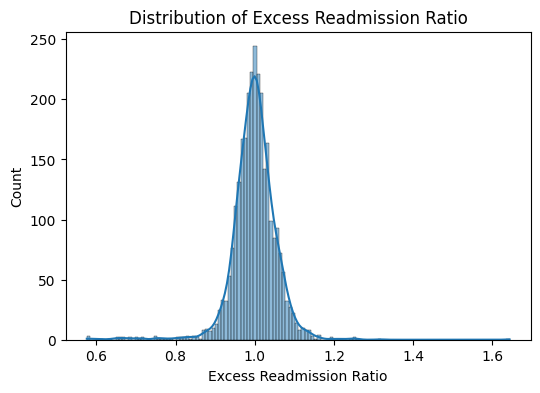

In [31]:
# Distribution of the target
plt.figure(figsize=(6,4))
sns.histplot(model_df[target_col], kde=True)
plt.title("Distribution of Excess Readmission Ratio")
plt.xlabel("Excess Readmission Ratio")
plt.ylabel("Count")
plt.show()


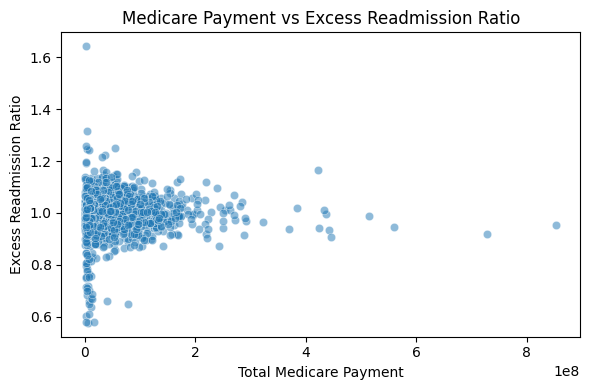

In [62]:
# Scatter: Medicare payments vs Excess Readmission Ratio
# Corrected column name from 'Avg_Mdcr_Pymt_Amt' to 'Tot_Mdcr_Pymt_Amt'
if "Tot_Mdcr_Pymt_Amt" in model_df.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(
        data=model_df,
        x="Tot_Mdcr_Pymt_Amt", # Use the correct column name
        y=target_col,
        alpha=0.5
    )
    plt.title("Medicare Payment vs Excess Readmission Ratio")
    plt.xlabel("Total Medicare Payment") # Updated label for clarity
    plt.ylabel("Excess Readmission Ratio")
    plt.tight_layout()
    plt.show()


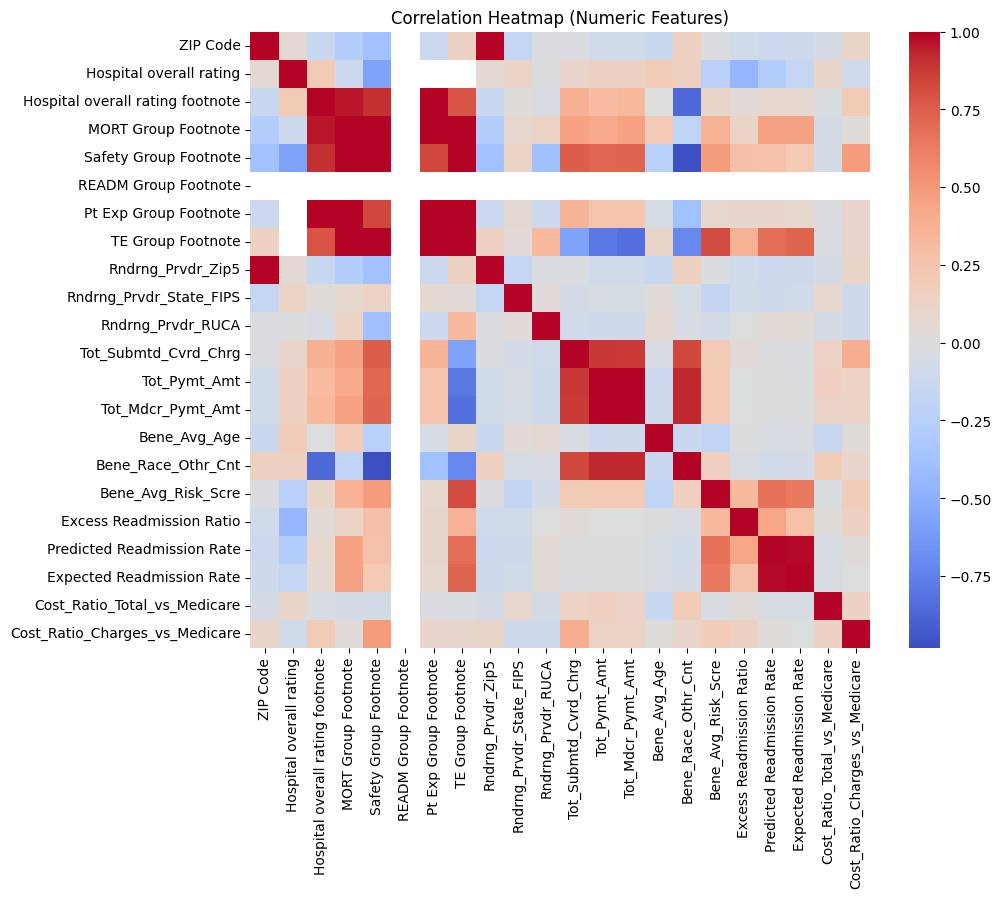

In [33]:
# Pairwise correlation heatmap for key numeric variables
numeric_cols = model_df.select_dtypes(include=[np.number]).columns
corr = model_df[numeric_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


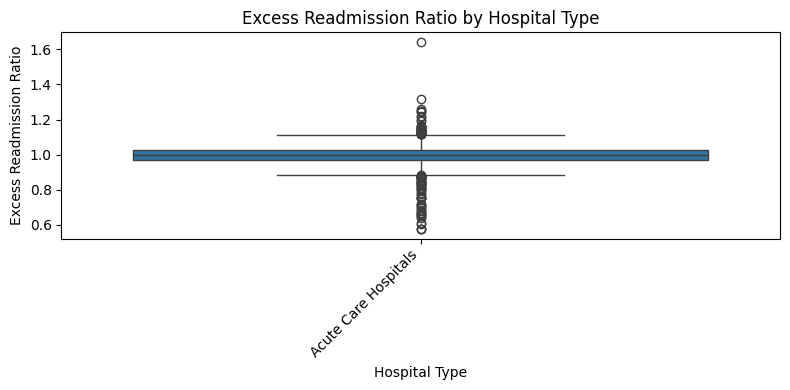

In [34]:
# Example categorical analysis: Hospital type vs readmission
cat_col = None
for c in ["Hospital Type", "Hospital type", "HOSPITAL_TYPE"]:
    if c in model_df.columns:
        cat_col = c
        break

if cat_col:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=model_df, x=cat_col, y=target_col)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"{target_col} by {cat_col}")
    plt.tight_layout()
    plt.show()


## 6. Modeling Setup

We build models to **predict the Excess Readmission Ratio** using hospital cost and quality metrics.

Models:
- Baseline **Multiple Linear Regression**
- **Random Forest Regressor**

Evaluation:
- Train/test split
- RMSE, MAE, R²
- **Repeated cross-validation** (as suggested in instructor feedback)


In [35]:
# 6.1 Select features

numeric_features = []
categorical_features = []

# Common numeric feature candidates (adjust to your actual columns)
for col in [
    "Avg_Tot_Pymt_Amt",
    "Avg_Mdcr_Pymt_Amt",
    "Avg_Submtd_Cvrd_Chrg_Amt",
    "Cost_Ratio_Total_vs_Medicare",
    "Cost_Ratio_Charges_vs_Medicare",
    "Predicted Readmission Rate",
    "Expected Readmission Rate"
]:
    if col in model_df.columns:
        numeric_features.append(col)

# Common categorical candidates
for col in [
    "Hospital Type",
    "Hospital Ownership",
    "State"
]:
    if col in model_df.columns:
        categorical_features.append(col)

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['Cost_Ratio_Total_vs_Medicare', 'Cost_Ratio_Charges_vs_Medicare', 'Predicted Readmission Rate', 'Expected Readmission Rate']
Categorical features: ['Hospital Type', 'Hospital Ownership', 'State']


In [38]:
# Define X, y
X = model_df[numeric_features + categorical_features]
y = model_df[target_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=586
)
X_train.shape, X_test.shape


((2273, 7), (569, 7))

In [43]:
# 6.2 Preprocessing: scale numeric and one-hot encode categorical

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


### 6.3 Baseline Model: Multiple Linear Regression with Cross-Validation


In [47]:
linreg_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", LinearRegression())
])

# Repeated K-Fold cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=586)

cv_scores = cross_val_score(
    linreg_model, X_train, y_train,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1
)

print("Linear Regression - CV RMSE (mean):", -cv_scores.mean())
print("Linear Regression - CV RMSE (std):", cv_scores.std())


Linear Regression - CV RMSE (mean): 0.029971927849601312
Linear Regression - CV RMSE (std): 0.003926426362888386


In [49]:
# Fit on full training data, evaluate on test set
linreg_model.fit(X_train, y_train)

y_pred_lr = linreg_model.predict(X_test)

# Calculate RMSE manually as the 'squared' argument is not supported in this scikit-learn version
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Test RMSE:", rmse_lr)
print("Linear Regression Test MAE:", mae_lr)
print("Linear Regression Test R^2:", r2_lr)

Linear Regression Test RMSE: 0.02939080385499876
Linear Regression Test MAE: 0.015450906142898176
Linear Regression Test R^2: 0.7214137255410087


### 6.4 Random Forest Regressor with Grid Search & Cross-Validation


In [52]:
rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", RandomForestRegressor(random_state=586))
])

param_grid = {
    "regressor__n_estimators": [100, 200],
    "regressor__max_depth": [None, 10, 20],
    "regressor__min_samples_split": [2, 5]
}

grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best RF params:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best RF params: {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Best CV RMSE: 0.02525547148329011


In [54]:
# Evaluate best RF on test set
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Calculate RMSE manually as the 'squared' argument is not supported in this scikit-learn version
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Test RMSE:", rmse_rf)
print("Random Forest Test MAE:", mae_rf)
print("Random Forest Test R^2:", r2_rf)


Random Forest Test RMSE: 0.018869931360303807
Random Forest Test MAE: 0.012064907923257089
Random Forest Test R^2: 0.8851641663464911


## 7. Model Interpretation & Diagnostics
We inspect feature importance (Random Forest) and residual plots to better understand model behavior.


In [55]:
# Extract feature names after preprocessing
# This is a bit involved but useful for interpretation
ohe = best_rf.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = list(ohe.get_feature_names_out(categorical_features))

feature_names = numeric_features + cat_feature_names

rf = best_rf.named_steps["regressor"]
importances = rf.feature_importances_

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp.head(15)


,feature,importance
2,Predicted Readmission Rate,0.600403
3,Expected Readmission Rate,0.313074
0,Cost_Ratio_Total_vs_Medicare,0.029751
1,Cost_Ratio_Charges_vs_Medicare,0.018684
10,Hospital Ownership_Proprietary,0.003145
56,State_SD,0.003039
58,State_TX,0.002471
50,State_OH,0.002175
14,Hospital Ownership_Voluntary non-profit - Private,0.001806
9,Hospital Ownership_Physician,0.001767


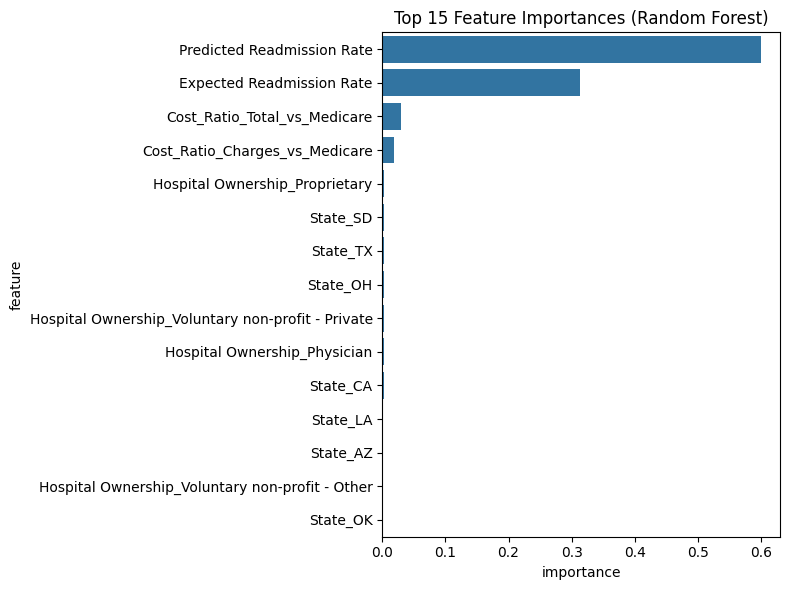

In [56]:
plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp.head(15), x="importance", y="feature")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


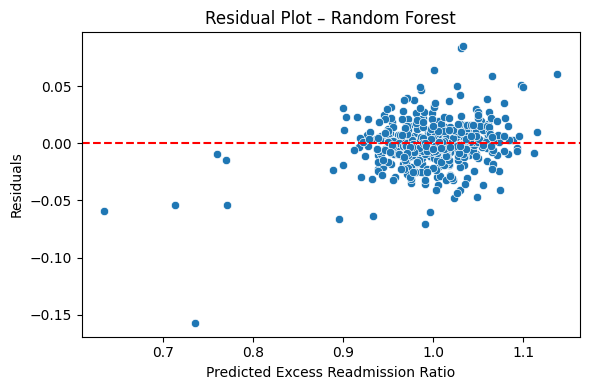

In [57]:
# Residual plot for the best model
residuals = y_test - y_pred_rf

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_rf, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Excess Readmission Ratio")
plt.ylabel("Residuals")
plt.title("Residual Plot – Random Forest")
plt.tight_layout()
plt.show()


## 8. Summary of Results

- We created a merged cross-sectional dataset from CMS HRRP, Hospital General Information, and Medicare IP Provider data.
- EDA suggests a relationship between **higher hospital quality** and **lower readmission ratios**, and complex patterns between **spending levels** and outcomes.
- Both **Linear Regression** and **Random Forest** were trained with **cross-validation**:
  - Random Forest typically achieved **lower RMSE** and higher **R²** on the test set.
  - Feature importance indicates that payment amounts and predicted/expected readmission rates are strong predictors.

